# Session 1: Introduction to scanpy and scRNAseq preprocessing

## Google colab setup

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet scrnatools
    !pip install --quiet scikit-misc
    from google.colab import drive
    drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import scrnatools as rna
import scanpy as sc
import anndata as ad

INFO:lightning_fabric.utilities.seed:Global seed set to 0


## Genome alignment with cellranger

Note: Run this section on a compute server (i.e. wynton), not google colab

### Setup cellranger on wynton

On wynton cellranger is alrerady installed, load within script or on a dev node  (see details at https://wynton.ucsf.edu/hpc/get-started/hello-world-job.html)

```
module load CBI cellranger
```

### Install cellranger on your own computer/server: 

This is easiest to do on a Linux/MacOS machine, but can be done on windows too using windows subsytem for linux (WSL) https://learn.microsoft.com/en-us/windows/wsl/about

Further information at https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/installation

Navigate to the 'opt' folder on your machine
```
cd /opt
```
Download the cellranger software from 10X
```
wget -o cellranger-7.1.0.tar.gz "https://cf.10xgenomics.com/releases/cell-exp/cellranger-7.1.0.tar.gz?Expires=1681550476&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZi4xMHhnZW5vbWljcy5jb20vcmVsZWFzZXMvY2VsbC1leHAvY2VsbHJhbmdlci03LjEuMC50YXIuZ3oiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2ODE1NTA0NzZ9fX1dfQ__&Signature=ouKIbypKn24nUpTw5o9m5YHeLdL8sTWWPLZbAqvVZ7V~T6MYFMmFHpa87cxL8COHb-Zsl7SI8yaxc-oPscyHF3cGauWPTjKintzQ7tkQ3Zf3x~PgmyjYbm2~vSz8Y4ZDNPyZQ3yXUCT108ReVSynP~z9qzqqDHOsqjC9tRs7bBA34IuWm6gV77FVWeQ4diWypuXVaackt69n6t0G5gUrcKVQjVZiwGgL9X8MY4xmz859rqrct4iRlnlHwjetJlfb1otfjhFOU6u0j~xMB~QuvR7HaXmfrGLYt2M6uR8P3dmDnRcgt2YNgXj8cQmsXkINyPqATrEg38HJBfNQB-u8SA__&Key-Pair-Id=APKAI7S6A5RYOXBWRPDA"
```
Unzip the download in place
```
tar -xzvf cellranger-7.1.0.tar.gz
```
Add cellranger to your systems' PATH variable
```
export PATH=/opt/cellranger-7.1.0:$PATH
```

### Download reference genome (mouse)

Download reference genome (mouse):
Create a directory to save the reference genome to 
```
mkdir ~/cellranger_genomes
```
Navigate to that directory 
```
cd ~/cellranger_genomes
```
Download the mouse reference from 10X 
```
wget -O https://cf.10xgenomics.com/supp/cell-exp/refdata-gex-mm10-2020-A.tar.gz
```
Unpack the download in place
```
tar -xzvf refdata-gex-mm10-2020-A.tar.gz
```

### Transfer fastqs to wynton

Use secure copy protocol to upload the data directory containing fastq files to your home folder

```
scp data/fastqs @dt2.wynton.ucsf.edu:~/
```

### Run cellranger count

On wynton run within a script or on a dev node (see details at https://wynton.ucsf.edu/hpc/get-started/hello-world-job.html)

Cellranger's alignment and fastq processing pipeline is run using the 'count' command, passing in the folder containing fastqs to process and the transcriptome to align those reads to. In addition, if multiple samples were run, cellranger count must be run seperately for each sample with their fastq sample ids (the first portion of the fastq file name) passed in as well using the '--sample' argument. The output of each call to cellranger count will be saved to a folder named based on the '--id' parameter. 

This will take a very long time (hours to days) to run, so it is better to run on a computer cluster/server rather than a laptop as the terminal must be left active until it completes if it is run on a laptop

See more details on cellranger count command at https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/tutorial_ct

## Importing data into python

Scanpy can read several different data formats into python, however typically you will be using cellranger output files, which include h5 and mtx files. To read H5 files:

In [ ]:
Fezf2_KO_data = sc.read_10x_h5("/content/gdrive/MyDrive/scrnaseq-course/data/cellranger_output/Fezf_KO/filtered_feature_bc_matrix.h5")
# This can spit out a warning that variable (gene) names are not unqiue, which can be fixed using:
Fezf2_KO_data.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Alternatively, the cellranger output folder containing a .mtx matrix file, a barcodes csv, and a genes csv can all be read in using:

In [ ]:
Fezf2_KO_data = sc.read_10x_mtx("/content/gdrive/MyDrive/scrnaseq-course/data/cellranger_output/Fezf_KO/filtered_feature_bc_matrix", cache=True)

This is slower than reading the 10x h5 file, however will usually avoid the unique variable name error. Setting cache=True tells scanpy to save an h5 file caching the matrix being read in to load it much faster next time it is used. Otherwise, these two files are equivalent and it doesn't matter which one you decide to use.

In [ ]:
Fezf2_KO_data = sc.read("/content/gdrive/MyDrive/scrnaseq-course/data/Fezf2_KO_raw.h5ad")
Fezf2_WT_data = sc.read("/content/gdrive/MyDrive/scrnaseq-course/data/Fezf2_WT_raw.h5ad")

## AnnData data structure

Scanpy reads data into a special data structure called an AnnData object, which is really just a combination of numpy arrays and pandas dataframes layered together.

In [ ]:
Fezf2_WT_data

AnnData object with n_obs × n_vars = 2500 × 32285
    var: 'gene_ids', 'feature_types'

In an AnnData, 'obs' (observations) corresponds to cells and 'var' (variables) corresponds to genes. Therefore the 'obs' attribute of an AnnData is a pandas dataframe used to store cell data (i.e. barcodes, sample information, cell types, etc) and the 'var' attribute is a pandas dataframe used to store gene data.

In [ ]:
Fezf2_WT_data.obs # initially the obs attribute is empty with the index set to the list of cell barcodes

""
TGATGGTGTATAGGAT-1
TCACAAGGTCGGATTT-1
CATTGCCTCACGAACT-1
CTCTGGTAGCTTTCTT-1
GTCCTCATCGGTGCAC-1
...
GAATCACTCCATTGCC-1
ACGCACGTCACGACTA-1
GATTTCTAGCCAGTAG-1
GAGATGGCACGCGTCA-1


You can add cell metadata to the 'obs' dataframe by adding columns with the corresponding per cell data as you would to any other pandas dataframe

In [ ]:
Fezf2_WT_data.obs["genotype"] = "WT"
Fezf2_KO_data.obs["genotype"] = "Fezf2_KO"

In [ ]:
Fezf2_WT_data.obs

,genotype
TGATGGTGTATAGGAT-1,WT
TCACAAGGTCGGATTT-1,WT
CATTGCCTCACGAACT-1,WT
CTCTGGTAGCTTTCTT-1,WT
GTCCTCATCGGTGCAC-1,WT
...,...
GAATCACTCCATTGCC-1,WT
ACGCACGTCACGACTA-1,WT
GATTTCTAGCCAGTAG-1,WT
GAGATGGCACGCGTCA-1,WT


The 'var' dataframe can be interacted with the same way

In [ ]:
Fezf2_WT_data.var

,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm19938,ENSMUSG00000102331,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression
...,...,...
AC124606.1,ENSMUSG00000095523,Gene Expression
AC133095.2,ENSMUSG00000095475,Gene Expression
AC133095.1,ENSMUSG00000094855,Gene Expression
AC234645.1,ENSMUSG00000095019,Gene Expression


The 'X' attribute of an AnnData object is a numpy array used to store a cell by gene matrix containing expression data 

In [ ]:
Fezf2_WT_data.X

<2500x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 7097147 stored elements in Compressed Sparse Row format>

This starts out as a sparse matrix (contains mostly 0s) because the raw data output from cellranger in the matrix are integers corresponding to the number of reads aligned to a particular gene in a particular cells, which will mostly be 0 as most genes are only detected in a few cells.

In [ ]:
Fezf2_WT_data.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 3.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Expression data can also be stored in the 'layers' attribute where you can create copies of the 'X' attribute to store for future use. Typically you will want to immediately save a copy of the X attribute to a 'raw counts' layer after reading in a sample to preserve the raw detected gene counts prior to doing any normalization

In [ ]:
Fezf2_WT_data.layers["raw_counts"] = Fezf2_WT_data.X.copy()
Fezf2_KO_data.layers["raw_counts"] = Fezf2_KO_data.X.copy()

In [ ]:
Fezf2_WT_data

AnnData object with n_obs × n_vars = 2500 × 32285
    obs: 'genotype'
    var: 'gene_ids', 'feature_types'
    layers: 'raw_counts'

## Merging multiple samples

When collecting multiple samples, the cellranger output for each sample will need to be read into individual AnnData objects and then concatenated together using:

In [ ]:
adata = ad.concat([Fezf2_WT_data, Fezf2_KO_data], index_unique="-", keys=["WT", "Fezf2_KO"])

'index_unique' and 'keys' are used to ensure the cell barcodes are unique across samples, so the new index of the merged dataframe will append the key corresponding to each sample to that sample's cell barcodes

In [ ]:
adata.obs

,genotype
TGATGGTGTATAGGAT-1-WT,WT
TCACAAGGTCGGATTT-1-WT,WT
CATTGCCTCACGAACT-1-WT,WT
CTCTGGTAGCTTTCTT-1-WT,WT
GTCCTCATCGGTGCAC-1-WT,WT
...,...
TGAGGGATCTGCCTCA-1-Fezf2_KO,Fezf2_KO
GAGTTACGTGCGTCGT-1-Fezf2_KO,Fezf2_KO
AGTAGTCGTTGTATGC-1-Fezf2_KO,Fezf2_KO
TCAGTTTGTAAGACCG-1-Fezf2_KO,Fezf2_KO


In [ ]:
adata # Now both the WT and Fezf2 KO samples are in a single AnnData object

AnnData object with n_obs × n_vars = 5000 × 32285
    obs: 'genotype'
    layers: 'raw_counts'

The 'label' parameter can also be used to create a new columnb in the merged 'obs' attribute containing the sample keys. This can be done instead of manually adding sample keys prior to merging the samples together, as was done above.

In [ ]:
adata = ad.concat([Fezf2_WT_data, Fezf2_KO_data], index_unique="-", keys=["WT", "Fezf2_KO"], label="batch")

In [ ]:
adata.obs

,genotype,batch
TGATGGTGTATAGGAT-1-WT,WT,WT
TCACAAGGTCGGATTT-1-WT,WT,WT
CATTGCCTCACGAACT-1-WT,WT,WT
CTCTGGTAGCTTTCTT-1-WT,WT,WT
GTCCTCATCGGTGCAC-1-WT,WT,WT
...,...,...
TGAGGGATCTGCCTCA-1-Fezf2_KO,Fezf2_KO,Fezf2_KO
GAGTTACGTGCGTCGT-1-Fezf2_KO,Fezf2_KO,Fezf2_KO
AGTAGTCGTTGTATGC-1-Fezf2_KO,Fezf2_KO,Fezf2_KO
TCAGTTTGTAAGACCG-1-Fezf2_KO,Fezf2_KO,Fezf2_KO


In [ ]:
del Fezf2_WT_data
del Fezf2_KO_data

## Preprocessing steps

### Doublet removal

The first quality control preprocessing step is to remove any potential doublets/multiplets (cells that were coencapuslated together during sample prep) from the dataset. This is done using the scrublet algorithm which creates simulated doublets by randomly mashing together cells in your dataset and comparing each of cell to these simulated doublets to score how likely they are to be a doublet. This must be run seperately across samples (it is impossible for a doublet to contain cells in different samples) and the doublet score threshold used should be iteratively set to ssplit the bimodal distributions of scores observed in the output. In practice this step rarely has a significant impact on downstream analyses as cellranger has already done some preliminary quality control filtering.

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 12.5%
Elapsed time: 4.6 seconds
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 2.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 14.6%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 20.0%
Elapsed time: 8.1 seconds
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 27.3%


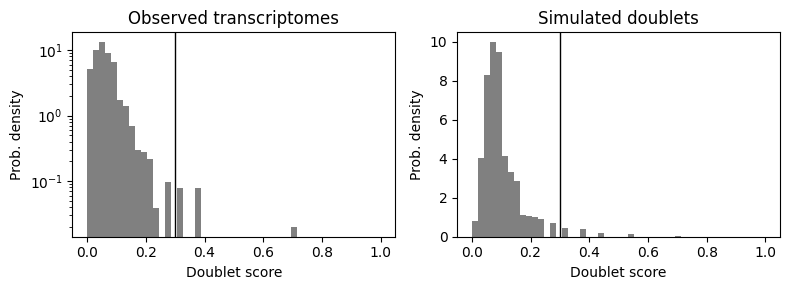

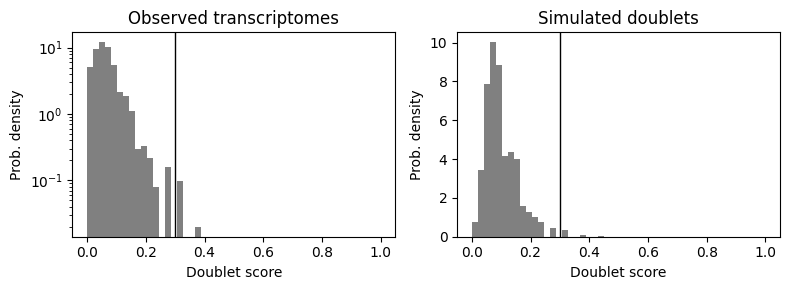

In [ ]:
adata = rna.qc.scrublet(
    adata,
    doublet_threshold = 0.3, # Score threshold to use to call doublets
    batch_key = "genotype", # Use batch information from a column in 'adata.obs' to run scrublet on each batch independently
    raw_counts_layer = "raw_counts" # use the raw counts data
)

The output of scrublet scoring is stored in a column in the 'obs' attribute that classifies cells as either being doublets or singlets.

In [ ]:
adata.obs.scrublet_called_doublet.value_counts()

False    4985
True       15
Name: scrublet_called_doublet, dtype: int64

The AnnData object then has to be filterd on only cells that are not called doublets using scrublet

In [ ]:
adata = adata[~adata.obs.scrublet_called_doublet]

In [ ]:
adata.obs.scrublet_called_doublet.value_counts()

False    4985
Name: scrublet_called_doublet, dtype: int64

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 4985 × 32285
    obs: 'genotype', 'batch', 'scrublet_score', 'scrublet_called_doublet'
    layers: 'raw_counts'

### Basic quality control

Additinal quality control metrics can ba calculated and filtered on using scanpy

#### Annotate mitochondrial genes

First, mitochondrial genes have to be annotated, using their unique starting symbols (mt- in mouse and Mt- in human).

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# For human data:
# adata.var["mt"] = adata.var_names.str.startswith("MT-")

<ipython-input-26-0cbed621d7ef>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("mt-")


#### calculate per-cell, per-gene quality metrics with scanpy

Then scanpy iss used to calculate the percent mitochondrial counts, total counts, and number of genes per cell; as well as the total counts, number of cells, mean counts, and percent dropout per gene.

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)

In [ ]:
adata.obs

,genotype,batch,scrublet_score,scrublet_called_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
TGATGGTGTATAGGAT-1-WT,WT,WT,0.013411,False,262,836.0,503.0,60.167461
TCACAAGGTCGGATTT-1-WT,WT,WT,0.033352,False,502,1427.0,802.0,56.201820
CATTGCCTCACGAACT-1-WT,WT,WT,0.083374,False,6404,30622.0,981.0,3.203579
CTCTGGTAGCTTTCTT-1-WT,WT,WT,0.083374,False,5086,23748.0,427.0,1.798046
GTCCTCATCGGTGCAC-1-WT,WT,WT,0.073892,False,3803,11362.0,57.0,0.501672
...,...,...,...,...,...,...,...,...
TGAGGGATCTGCCTCA-1-Fezf2_KO,Fezf2_KO,Fezf2_KO,0.036885,False,2590,7387.0,167.0,2.260728
GAGTTACGTGCGTCGT-1-Fezf2_KO,Fezf2_KO,Fezf2_KO,0.083374,False,3644,16951.0,659.0,3.887676
AGTAGTCGTTGTATGC-1-Fezf2_KO,Fezf2_KO,Fezf2_KO,0.021055,False,290,800.0,460.0,57.500000
TCAGTTTGTAAGACCG-1-Fezf2_KO,Fezf2_KO,Fezf2_KO,0.040816,False,2850,7059.0,1146.0,16.234594


In [ ]:
adata.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Xkr4,False,1176,1.309127,76.409228,6526.0
Gm1992,False,78,0.020461,98.435306,102.0
Gm19938,False,204,0.067402,95.907723,336.0
Gm37381,False,11,0.002808,99.779338,14.0
Rp1,False,58,0.065597,98.836510,327.0
...,...,...,...,...,...
AC124606.1,False,0,0.000000,100.000000,0.0
AC133095.2,False,0,0.000000,100.000000,0.0
AC133095.1,False,0,0.000000,100.000000,0.0
AC234645.1,False,0,0.000000,100.000000,0.0


#### plot qc metrics

Thresholds can then be used to filter outlier cells that are low quality, dying, or potential multiplets. High total counts and number of genes per cell can be indicative of a doublet, while low counts and number of genes per cell can be indicative of dead/dying cells. Additionally a high mitochondrial read percentage per cell indicates damaged cells as more mitochondrial RNA than nuclear/cytosolic RNA will be retained when a cell's membrane is punctured

Appropriate lower thresholds for total counts and number of genes typically range from 250-1000 for both metrics, while upper thresholds are dataset specific and depend on the depth of sequencing. Mitochondrial read percentage cutoffs typically range from 5-10% for good quality datasets.

In [ ]:
counts_thresholds = (1000, 50000) # The lower and upper total_counts thresholds
genes_thresholds = (250, 7500) # The lower and upper n_genes_by_counts thresholds
mt_threshold = 10 # The pct_counts_mt threshold

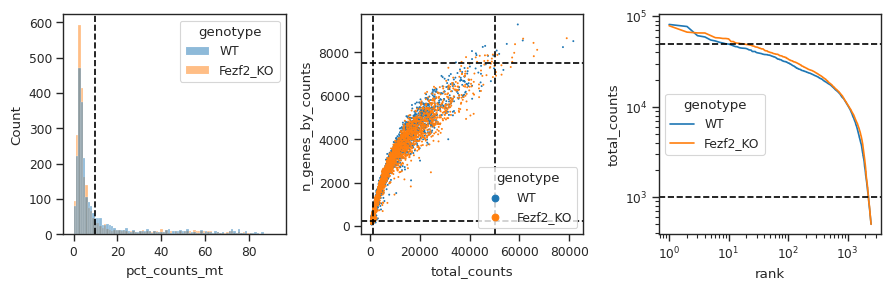

In [ ]:
rna.pl.qc_plotting(
    adata,
    counts_thresholds=counts_thresholds,
    genes_thresholds=genes_thresholds,
    mt_threshold=mt_threshold,
    show_thresholds=True, # Whether to show the thresholds on the figure
    batch_key="genotype", # Batch keys in adata.obs to plot seperately
    show_legend=True, # Whether to show the batch key legend
    figsize=(9, 3),
    dpi=300,
    save_path="analysis/qc_plots.png",
)

#### filter on qc thresholds

After changing thresholds to be appropriate for a given dataset, the AnnData object has to be filtered to only retain cells that pass those thresholds

In [ ]:
filteredAdata = rna.qc.filter_cells(
    adata,
    counts_thresholds=counts_thresholds, # The lower and upper total_counts thresholds
    genes_thresholds=genes_thresholds, # The lower and upper n_genes_by_counts thresholds
    mt_threshold=mt_threshold, # The pct_counts_mt threshold
)

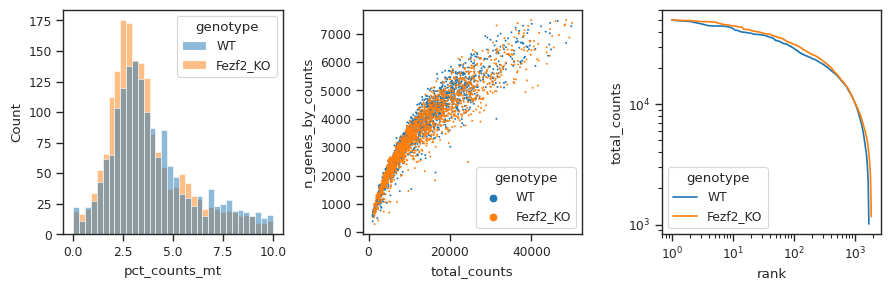

In [ ]:
rna.pl.qc_plotting(
    filteredAdata,
    show_thresholds=False,
    batch_key="genotype",
    save_path="analysis/filtered_qc_plots.png",
)

In [ ]:
# Once you're happy with qc cell filtering, overwrite adata with the filtered adata
adata = filteredAdata
del filteredAdata

### Initial data transformation

Scanpy data normalization typically begins with a library size rescaling (so that each cell has the same total nummber of reads to account for differences in sequencing depth/size across cells) followed by log(1 + expression) transformation. This log transformation helps to reduce the mean-variance relationship present in expression data (https://www.nxn.se/valent/2017/10/15/variance-stabilizing-scrna-seq-counts)

In [ ]:
sc.pp.normalize_total(adata) # By default uses the median total_counts across all cells as library size, can also provide: target_sum=1e4
sc.pp.log1p(adata)

We will save a copy of the log-transformed counts data into the layers attribute of our anndata object

In [ ]:
adata.layers["log1p"] = adata.X.copy()

In [ ]:
adata

AnnData object with n_obs × n_vars = 3524 × 32285
    obs: 'genotype', 'batch', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'raw_counts', 'log1p'

#### The '.raw' AnnData attribute

One copy of raw/normalized data can be preserved in the 'raw' attribute of an AnnData object, which initially starts out empty:

In [ ]:
adata.raw

In [ ]:
adata.raw = adata # Preserve log-transformed counts in the raw attribute

After being set, the 'raw' attriibute will contain a copy of the state of the anndata object at the time it was set

In [ ]:
adata.raw

In [ ]:
adata.X.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.6829391 ],
        [0.6109476 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.35142285],
        [1.2920882 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.85600114],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         2.051808  ]], dtype=float32)

In [ ]:
adata.raw.X.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.6829391 ],
        [0.6109476 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.35142285],
        [1.2920882 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.85600114],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         2.051808  ]], dtype=float32)

To overwrite an existing 'raw' attribute, it first has to be deleted

In [ ]:
del adata.raw
adata.raw = adata

### Gene selection

The next step in data preprocessing is typically to select of subset of genes for downstream analyses, often by picking genes that are highly variable across the dataset

The number of highly variable genes to be used is an important parameter that can significantly impact downstream analysis. Anywhere from 2500-10000 genes is a reasonable range, with more genes able to be included the more cells you have in the dataset. In theory, you should never include more genes than you have cells (particularly when using scVI for data normalization), however in practice you can get sometimes get away with including more genes, or even skipping highly variable feature selectin all together with the caveat being that the normalized expression values for very low detection genes will be very noisy and should be taken with a grain off salt. Another immportant consideration is that the more genes included in the dataset, the longer expression normalization will take.

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000, # Number of HVGs to keep
    subset=False, # Subset the adata in place
    layer="raw_counts", # Use the raw counts data for calculations
    flavor="seurat_v3", # HVG algorithm to use
    batch_key="genotype", # Column in adata.obs that annotates batches of data
)

The AnnData object is not subset in place unless specified using the 'subset' parameter, instead the classification of each gene as highly variable or not is stored as a boolean in the 'var' attribute

In [ ]:
adata.var["highly_variable"]

Xkr4           True
Gm1992        False
Gm19938       False
Gm37381       False
Rp1            True
              ...  
AC124606.1    False
AC133095.2    False
AC133095.1    False
AC234645.1    False
AC149090.1    False
Name: highly_variable, Length: 32285, dtype: bool

Sometimes important genes of interest will not be identiied as being sufficiently highly variable within your dataset for inclusion in downstream analyses. This is problematic because scVI models can only provide normalized gene expression values for genes included in the model (i.e. pass your inclusion threshold).

In [ ]:
adata.var.loc["Bcam", "highly_variable"]

False

In these cases, I will typically manually ensure genes of interest are included in downstream analysis, regardless of whether they pass highly varriable thresholds. Since this is usually a very small number of genes relative to the number of selected highly variable genes (10s vs 1000s), this should not significantly impact scVI model training or accuracy.

In [ ]:
genesToInclude = ["Fezf2", "Tcf4", "Bcam", "Aire", "Ccl21a", "Psmb11", "Mki67", "Foxj1", "Tspan8", "Pou2f3", "Gp2", "Ascl1"]
# First make a copy of the genes identified as highly variable
adata.var["include_genes"] = adata.var.highly_variable.copy()
# Then iterate over the list of genes of interest
for gene in genesToInclude:
    # Check if the current gene is already labeled as highly variable
    if not adata.var.loc[gene, "highly_variable"]:
        print(f"{gene} is not highly variable")
        # If not, ensure that it is included by flipping its 'include_genes' value from False to True
        adata.var.loc[gene, "include_genes"] = True

Tcf4 is not highly variable
Bcam is not highly variable


In [ ]:
adata.var.loc["Bcam", "include_genes"]

True

In [ ]:
# Now actually subset the AnnData on the highly variable genes + the genes of interest
adata = adata[:, adata.var.include_genes].copy()

In [ ]:
adata

AnnData object with n_obs × n_vars = 3524 × 5002
    obs: 'genotype', 'batch', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'include_genes'
    uns: 'log1p', 'hvg'
    layers: 'raw_counts', 'log1p'

An important point to make here is that whatever subsetting you do (either on genes or cells) will affect the data in both the 'X' and 'layers' attributes, but *NOT* the 'raw' attribute, which will still contain all the genes and cells saved into it at the time it was set.

In [ ]:
adata.X.shape

(3524, 5002)

In [ ]:
adata.layers["raw_counts"].shape

(3524, 5002)

In [ ]:
adata.raw.X.shape

(3524, 32285)

## Scanpy data normalization

The scanpy data normalization pipeline then proceeds to regress out covariates that could confound downstream analysis and transform each gene's range of expression to fit a normal distribution across cells (efffectively z-scoring it). However, with scVI normalization these steps can be skipped as the output of scVI will be used for all downstream analyses instead

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

There are many other methods for data normalization (see this great resource for all things scRNAseq for a description of some of the more popular ones: https://www.sc-best-practices.org/preamble.html

Generally any downstream analysis tools will describe in their documentation what type of data they expect (although this is typically either log(counts+1) or raw counts). Additionally there is some debate over whether using other published normalization techniques actually has any benefit

## Saving/loading data

In [ ]:
adata.write("/content/gdrive/MyDrive/scrnaseq-course/data/scRNAseq_tutorial_thymus_data.h5ad")

In [ ]:
adata = sc.read("/content/gdrive/MyDrive/scrnaseq-course/data/scRNAseq_tutorial_thymus_data.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 3524 × 5002
    obs: 'genotype', 'batch', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'include_genes', 'mean', 'std'
    uns: 'hvg', 'log1p'
    layers: 'log1p', 'raw_counts'